In [1]:
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import pandas as pd
import numpy as np
import string
import re

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam

import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [2]:
# Download required NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
df = pd.read_csv('HateSpeechDatasetBalanced.csv')
print(df.head())


In [ ]:
print(df.info())
print(df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 726119 entries, 0 to 726118
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Content  726119 non-null  object
 1   Label    726119 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 11.1+ MB
None
               Label
count  726119.000000
mean        0.502018
std         0.499996
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000


class label for majority of CF users. 0 - hate speech 1 - offensive language 2 - neither

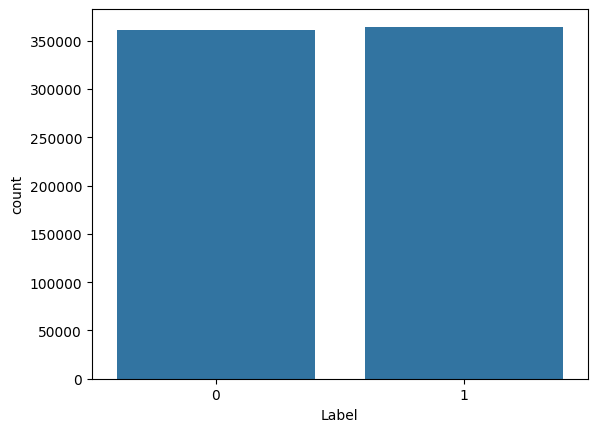

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# class label for majority of CF users. 0 - hate speech 1 - offensive language 2 - neither
sns.countplot(x='Label', data=df)
plt.show()


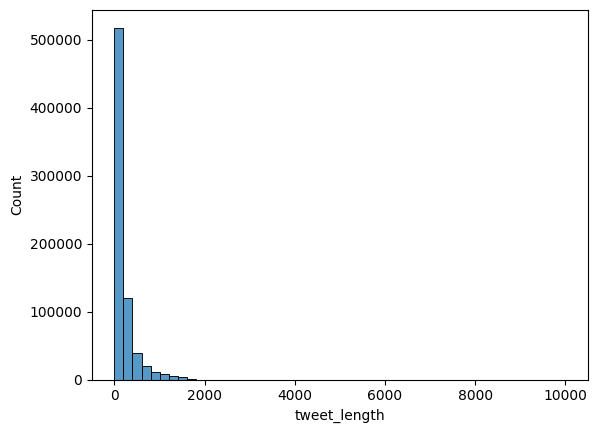

In [ ]:
df['tweet_length'] = df['Content'].apply(len)
sns.histplot(df['tweet_length'], bins=50)
plt.show()


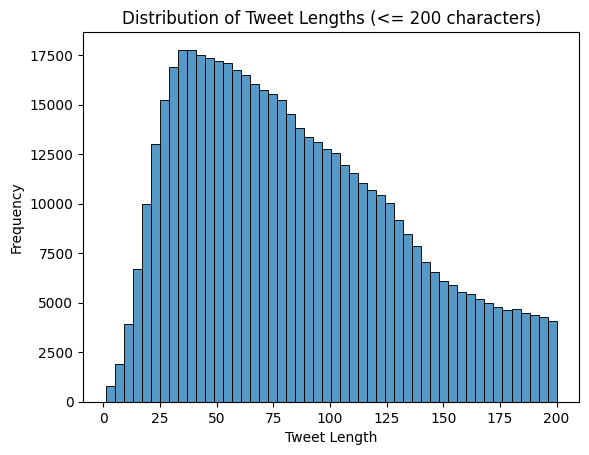

In [ ]:
# Filter the DataFrame to include only tweets with length <= 200
filtered_df = df[df['tweet_length'] <= 200]

# Plot the histogram
sns.histplot(filtered_df['tweet_length'], bins=50)
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.title('Distribution of Tweet Lengths (<= 200 characters)')
plt.show()


In [ ]:
filtered_df.count()

Content         518187
Label           518187
tweet_length    518187
dtype: int64

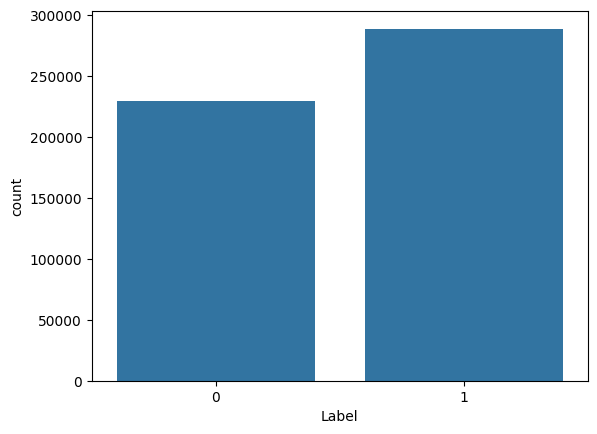

In [ ]:
# class label for majority of CF users. 0 - hate speech 1 - offensive language 2 - neither
sns.countplot(x='Label', data=filtered_df)
plt.show()

In [ ]:

# Randomly sample 10% of the data
sampled_df = filtered_df.sample(frac=0.1, random_state=42)

# Save the sampled data to a CSV file
sampled_df.to_csv('sampled_data.csv', index=False)

# Print the first few rows of the sampled data to verify
print(sampled_df.head())


                                                  Content  Label  tweet_length
402858  gee i recall saying there that the cited sourc...      0            94
44358   it is nice to tell everyone i have zero hatred...      1            79
696860           kad said pedophilia pride and i je na ko      1            40
536117  what about you all about the refugees that wou...      1           198
434344  aaaaaa manor he suicide amati eu ri ct ooooooo...      0           112


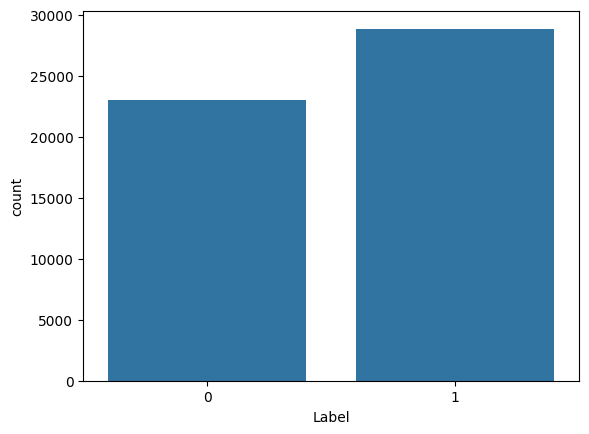

In [ ]:
# class label for majority of CF users. 0 - hate speech 1 - offensive language 2 - neither
sns.countplot(x='Label', data=sampled_df)
plt.show()

# Data Preprocessing

In [3]:
sampled_df= pd.read_csv('sampled_data.csv')
print(sampled_df.head())

                                             Content  Label  tweet_length
0  gee i recall saying there that the cited sourc...      0            94
1  it is nice to tell everyone i have zero hatred...      1            79
2           kad said pedophilia pride and i je na ko      1            40
3  what about you all about the refugees that wou...      1           198
4  aaaaaa manor he suicide amati eu ri ct ooooooo...      0           112


In [4]:

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Function to map POS tags to the format used by WordNetLemmatizer
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def clean_text(text):
    # Normalize text
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = ''.join([char for char in text if char not in string.punctuation])  # Remove punctuation
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords

    # Tokenize and lemmatize
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tokens]

    return ' '.join(tokens)



In [5]:
# Apply the clean_text function to the 'tweet' column
sampled_df['clean'] = sampled_df['Content'].apply(clean_text)

# Display the first few rows of the DataFrame to verify the cleaning process
sampled_df[['Content', 'clean']].head(5)

,Content,clean
0,gee i recall saying there that the cited sourc...,gee recall say cite source work hmmm wonder miss
1,it is nice to tell everyone i have zero hatred...,nice tell everyone zero hatred toward bumper s...
2,kad said pedophilia pride and i je na ko,kad say pedophilia pride je na ko
3,what about you all about the refugees that wou...,refugee would destroy canadian country radical...
4,aaaaaa manor he suicide amati eu ri ct ooooooo...,aaaaaa manor suicide amati eu ri ct oooooooooo...


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Instantiate the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2), min_df=5)

# Fit and transform the 'clean' column
tfidf_matrix = tfidf_vectorizer.fit_transform(sampled_df['clean']).toarray()

# Print the TF-IDF matrix
print(tfidf_matrix.shape)


(51819, 5000)


In [ ]:
X= tfidf_matrix
y= sampled_df['Label'].tolist()

In [ ]:

X = np.array([np.array(vec) for vec in X])
y = np.array(y)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
# score = lr_model.score(X_val, y_val)
y_pred = lr_model.predict(X_val)
print(classification_report(y_val, y_pred))
# print("Accuracy:", score)

              precision    recall  f1-score   support

           0       0.77      0.73      0.75      2300
           1       0.80      0.83      0.81      2882

    accuracy                           0.79      5182
   macro avg       0.78      0.78      0.78      5182
weighted avg       0.79      0.79      0.79      5182



In [ ]:
input_dim = X_train.shape[1]  # Number of features

# Define the model
model = Sequential()

model.add(layers.Dense(50, input_dim=input_dim, kernel_regularizer='l2', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(25, kernel_regularizer='l2', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(1, activation='sigmoid'))  # Use sigmoid for binary classification

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.01),
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 50)                  │         250,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 50)                  │             200 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 25)                  │             100 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 25)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 251,651 (983.01 KB)

 Trainable params: 251,501 (982.43 KB)

 Non-trainable params: 150 (600.00 B)

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=True,
                    validation_data=(X_val, y_val),
                    batch_size=32)

Epoch 1/20
1296/1296 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.6619 - loss: 1.4556 - val_accuracy: 0.6951 - val_loss: 1.1370
Epoch 2/20
1296/1296 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6781 - loss: 1.2033 - val_accuracy: 0.7001 - val_loss: 1.1203
Epoch 3/20
1296/1296 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6731 - loss: 1.1411 - val_accuracy: 0.6745 - val_loss: 1.2405
Epoch 4/20
1296/1296 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6779 - loss: 1.1307 - val_accuracy: 0.6845 - val_loss: 1.1930
Epoch 5/20
1296/1296 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6704 - loss: 1.1137 - val_accuracy: 0.7069 - val_loss: 1.0168
Epoch 6/20
1296/1296 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6748 - loss: 1.0954 - val_accuracy: 0.7103 - val_loss: 1.0369
Epoch 7/20
1296/1296 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6713 - loss: 1.0961 - val_accuracy: 0.6716 - val_loss: 1.0936
Epoch 8/20
1296/1296 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6800 - loss: 1.1159 -

In [ ]:
# Generate predictions
y_pred = model.predict(X_val)
y_pred = (y_pred > 0.5).astype(int)

# Print the classification report
print(classification_report(y_val, y_pred))

162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
              precision    recall  f1-score   support

           0       0.69      0.56      0.62      2300
           1       0.69      0.80      0.74      2882

    accuracy                           0.69      5182
   macro avg       0.69      0.68      0.68      5182
weighted avg       0.69      0.69      0.69      5182



In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.6928


#BERT

In [ ]:
!pip install bert

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for bert: filename=bert-2.2.0-py3-none-any.whl size=3746 sha256=8b4fecffcf9c963b08bfa394e3a815ae902626704a70240b182047e63b3c6abf
  Stored in directory: /root/.cache/pip/wheels/d0/97/c8/5775d57c323970511488d9b53ce66cf0ded394fe4b4f6e0afb
  Created wheel for erlastic: filename=erlastic-2.0.0-py3-none-any.whl size=6780 sha256=f1d2fe7425d721ca0de5f0a3572535b4e4221a8f9271bce4b8ca3a31f060954a
  Stored in directory: /root/.cache/pip/wheels/f5/ca/b1/ce71c2e0e9e0df3786697d06d53574be03ef86cd4fb0e2cb99
Successfully built bert erlastic


In [6]:
from transformers import BertTokenizer

# Load the pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
sampled_df['bert_tokens'] = sampled_df['Content'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True,
                                                                                   max_length=32,
                                                                                   padding='max_length',
                                                                                   truncation=True))
sampled_df[['Content','bert_tokens','Label']].head(5)

,Content,bert_tokens,Label
0,gee i recall saying there that the cited sourc...,"[101, 20277, 1045, 9131, 3038, 2045, 2008, 199...",0
1,it is nice to tell everyone i have zero hatred...,"[101, 2009, 2003, 3835, 2000, 2425, 3071, 1045...",1
2,kad said pedophilia pride and i je na ko,"[101, 10556, 2094, 2056, 21877, 3527, 21850, 6...",1
3,what about you all about the refugees that wou...,"[101, 2054, 2055, 2017, 2035, 2055, 1996, 8711...",1
4,aaaaaa manor he suicide amati eu ri ct ooooooo...,"[101, 13360, 11057, 2050, 6952, 2002, 5920, 25...",0


In [ ]:
# token distription without truncation or padding
# sampled_df['bert_tokens'].apply(len).describe()


,bert_tokens
count,51819.000000
mean,20.208900
std,10.067885
min,3.000000
25%,12.000000
50%,19.000000
75%,27.000000
max,86.000000


In [8]:
X = np.array(sampled_df['bert_tokens'].tolist())
y = np.array(sampled_df['Label'].tolist())

In [9]:
X_tensor = torch.tensor(X)
y_tensor = torch.tensor(y)

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [11]:
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size= batch_size, shuffle= False)
val_dataloader = DataLoader(val_dataset, batch_size= batch_size, shuffle= False)
test_dataloader = DataLoader(test_dataset, batch_size= batch_size, shuffle= False)

In [12]:
from transformers import BertForSequenceClassification

bert_model= BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [13]:
import torch
from torch.cuda.amp import autocast, GradScaler
from transformers import AdamW

optimizer = AdamW(bert_model.parameters(), lr=1e-5, weight_decay=0.01)
scaler = GradScaler()  # Initialize GradScaler for mixed-precision training

num_epoch = 5

total_train_loss = 0
total_val_loss = 0
train_loss = []
val_loss = []

for epoch in range(num_epoch):
    bert_model.train()
    total_train_loss = 0

    for batch in train_dataloader:
        input_ids, labels = batch
        input_ids, labels = input_ids.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass with mixed precision
        with autocast():
            outputs = bert_model(input_ids, labels=labels)
            loss = outputs.loss

        # Scales loss to avoid underflow during backward pass
        scaler.scale(loss).backward()

        # Unscales gradients and updates the optimizer
        scaler.step(optimizer)
        scaler.update()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_dataloader)
    train_loss.append(avg_train_loss)


    # Validation loop
    bert_model.eval()
    total_val_loss = 0  # Reset val loss for each epoch
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids, labels = batch
            input_ids, labels = input_ids.to(device), labels.to(device)

            with autocast():  # Also use mixed precision in validation
                outputs = bert_model(input_ids, labels=labels)
                loss = outputs.loss
                total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_dataloader)
    val_loss.append(avg_val_loss)
    print(f"Epoch {epoch + 1}/{num_epoch} -AVG_Train_Loss: {avg_train_loss:.4F} - AVG_Val_Loss: {avg_val_loss:.4f}")


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
<ipython-input-13-211250e35cea>:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # Initialize GradScaler for mixed-precision training
<ipython-input-13-211250e35cea>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
<ipython-input-13-211250e35cea>:51: FutureWarning: `torch.cuda.amp.autoc

Epoch 1/5 -AVG_Train_Loss: 0.4375 - AVG_Val_Loss: 0.3485
Epoch 2/5 -AVG_Train_Loss: 0.3008 - AVG_Val_Loss: 0.3375
Epoch 3/5 -AVG_Train_Loss: 0.2011 - AVG_Val_Loss: 0.3916
Epoch 4/5 -AVG_Train_Loss: 0.1320 - AVG_Val_Loss: 0.4254
Epoch 5/5 -AVG_Train_Loss: 0.0949 - AVG_Val_Loss: 0.4137


In [14]:
def compute_accuracy(predictions, labels):
    predicted_labels = torch.argmax(predictions, dim=1)
    correct_predictions = torch.eq(predicted_labels, labels).sum().item()
    accuracy = correct_predictions / len(labels)
    return accuracy



In [15]:
# step 6: evaluate the model by computing  accuracy, precision, recall, and F1-score
# Evaluation loop
bert_model.eval()
val_accuracy = 0
num_val_steps = 0

with torch.no_grad():
    for batch in val_dataloader:
        inputs_text, labels = batch
        inputs_text, labels = inputs_text.to(device), labels.to(device)

        outputs = bert_model(inputs_text)
        val_accuracy += compute_accuracy(outputs.logits, labels)
        num_val_steps += 1

avg_val_accuracy = val_accuracy / num_val_steps

print(f"Validation Accuracy: {avg_val_accuracy:.4f}")


Validation Accuracy: 0.8554


In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Evaluation loop
bert_model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        inputs_text, labels = batch
        inputs_text, labels = inputs_text.to(device), labels.to(device)

        outputs = bert_model(inputs_text)
        predicted_labels = torch.argmax(outputs.logits, dim=1)

        predictions.extend(predicted_labels.tolist())
        true_labels.extend(labels.tolist())


In [17]:
from sklearn.metrics import classification_report

# Print classification report
print(classification_report(true_labels, predictions))


              precision    recall  f1-score   support

           0       0.83      0.84      0.83      2317
           1       0.87      0.86      0.86      2865

    accuracy                           0.85      5182
   macro avg       0.85      0.85      0.85      5182
weighted avg       0.85      0.85      0.85      5182



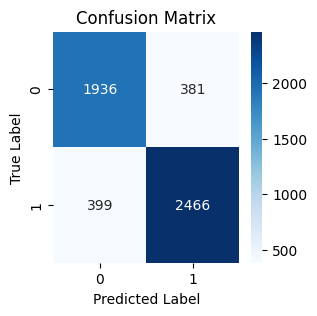

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(3, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['0','1'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()